In [9]:
# Import required libraries
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

In [10]:
# Connect to SQLite database
engine = create_engine('sqlite:///engine.db')

In [11]:
# reading the training dataset
training_dataset = pd.read_csv('dataset//train.csv')

# loading into db
training_dataset.to_sql('training_data', engine, if_exists='replace', index=False)

400

In [12]:
# reading the 50 ideal functions
ideal_functions = pd.read_csv('dataset//ideal.csv')

# loading into db
ideal_functions.to_sql('ideal_functions', engine, if_exists='replace', index=False)

400

In [13]:
def select_best_functions(engine, n_functions=4):
    """
    Selects the best n_functions ideal functions that minimize the sum of y-deviations squared (Least-Square).
    """

    # Read the training data and the ideal functions from the db
    training_data = pd.read_sql_query('SELECT * FROM training_data', engine)
    ideal_functions = pd.read_sql_query('SELECT * FROM ideal_functions', engine)

    # Initialize a dictionary to store the best functions for each training function
    best_functions = {}
    # This will hold the maximum deviations for each training function
    max_deviations = {}  

    # For each training function
    for training_func in ['y1', 'y2', 'y3', 'y4']:
        # Initialize a dictionary to store the sum of squared differences for each ideal function
        SSDs = {}

        # For each ideal function
        for ideal_func in ideal_functions.columns[1:]:
            # Calculate the sum of squared differences for the current function
            SSDs[ideal_func] = ((ideal_functions[ideal_func] - training_data[training_func]) ** 2).sum()

        # Sort the functions by their sum of squared differences
        sorted_SSDs = sorted(SSDs.items(), key=lambda x: x[1])

        # Select the best function
        best_function, min_SSD = sorted_SSDs[0]

        # Store the best function and the maximum deviation (sqrt of min_SSD) for the current training function
        best_functions[training_func] = best_function
        max_deviations[training_func] = np.sqrt(min_SSD) 

    # Return the best functions and the maximum deviations
    return best_functions, max_deviations

# Call the function to select the best functions
best_functions, max_deviations = select_best_functions(engine)

print("Best functions: ", best_functions, max_deviations)


Best functions:  {'y1': 'y1', 'y2': 'y6', 'y3': 'y28', 'y4': 'y12'} {'y1': 5.511435693522633, 'y2': 5.55558386008215, 'y3': 5.881104300639291, 'y4': 5.810492903024633}


In [14]:
def process_test_data(engine, best_functions, max_deviations):
    """
    Process the test data: for each x-y pair, assign it to one of the selected ideal functions if it meets the criterion.
    Save the results to a new table in the database.
    """

    # Read the test data and the ideal functions from the db
    test_data = pd.read_csv('dataset//test.csv')
    ideal_functions = pd.read_sql_query('SELECT * FROM ideal_functions', engine)

    # Prepare a DataFrame to store the results
    results = pd.DataFrame(columns=['X', 'Y', 'Delta_Y', 'Ideal Function'])

    # For each x-y pair in the test data
    for i, row in test_data.iterrows():
        x, y = row['x'], row['y']

        # Check against each of the selected ideal functions
        for training_func, ideal_func in best_functions.items():
            # Calculate the deviation from the ideal function
            deviation = abs(y - ideal_functions.loc[i, ideal_func])

            # If the deviation does not exceed the maximum deviation for this function, assign it
            if deviation <= max_deviations[training_func] * np.sqrt(2):
                results.loc[i] = [x, y, deviation, ideal_func]

                # Break the loop as we've found a match for this x-y pair
                break

    # Save the results to a new table in the db
    results.to_sql('test_data_results', engine, if_exists='replace', index=False)
    
# Process the test data
process_test_data(engine, best_functions, max_deviations)

testing_data = pd.read_sql_query('SELECT * FROM test_data_results', engine)

print (testing_data)


       X          Y   Delta_Y Ideal Function
0   -4.0   1.044171  1.957117             y1
1   -7.2   2.063293  2.876967             y1
2  -17.4  -1.217196  0.535233             y1
3  -10.2   1.789557  2.395097             y1
4    5.8   0.941599  1.376965             y1
5  -18.3   1.834888  2.178203             y1
6  -18.9  -0.088970  0.060908             y1
7    1.9  -0.880109  0.829686             y1
8    5.7   1.217443  1.167907             y1
9   -9.1  -0.544554  0.791527             y1
10   0.9   3.458527  3.116046             y1
11  -0.6  -0.483704  0.918269             y1
12  15.3  -0.128216  0.650525             y1
13 -13.3   0.423833  0.180999             y1
14   3.6   0.505708  0.361494             y1
15   4.1   0.329342  0.583240             y1
16  -3.9   1.998241  1.022615             y1
17 -15.4   0.458593  0.534067             y1
18  -1.6  -6.159616  7.159390             y1
19   4.0  -1.196281  2.157679             y1
20  16.0   0.002117  0.885450             y1
21  17.4  

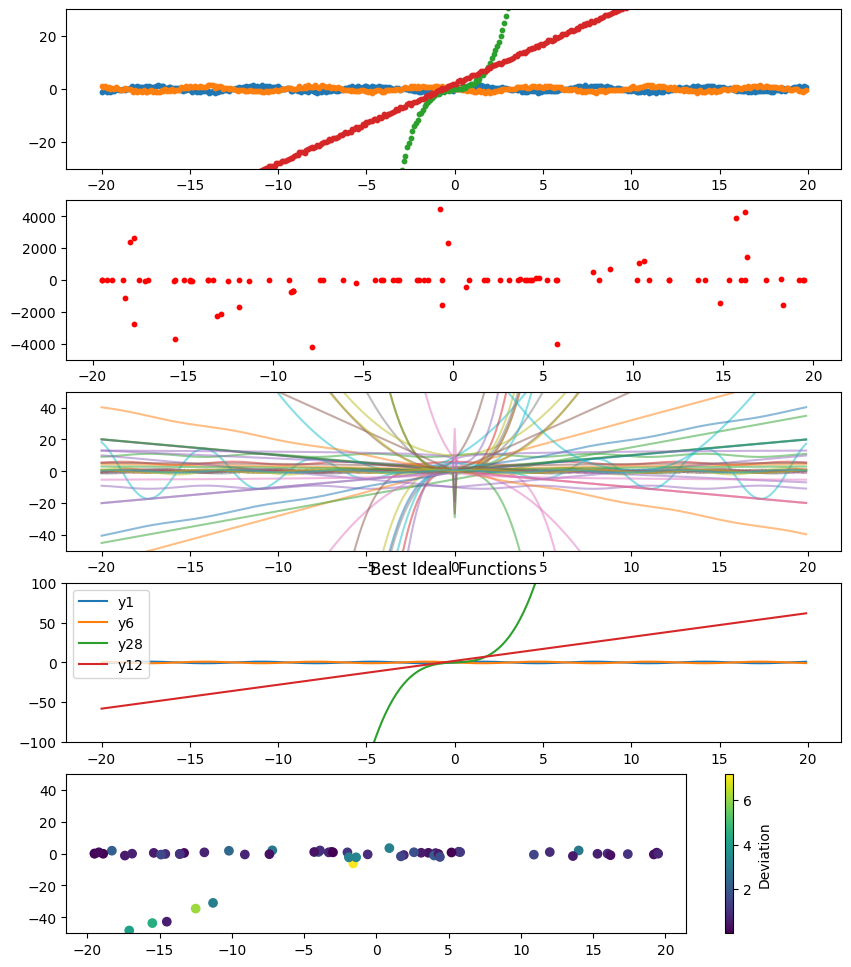

In [15]:
import matplotlib.pyplot as plt

def visualize_data(training_data, test_data, ideal_functions, best_functions, mapping_deviation):
    
    fig, axs = plt.subplots(len([x for x in [training_data, test_data, ideal_functions, best_functions, mapping_deviation] if x is not None]), figsize=(10, 12))
    
    # Plot training data
    if training_data is not None:
        for col in training_data.columns[1:]:
            axs[0].scatter(training_data['x'], training_data[col], label=f'Training Data {col}', s=10)
        axs[0].set_ylim(-30, 30)
    
    # Plot test data if provided
    if test_data is not None:
        axs[1].scatter(test_data['x'], test_data['y'], label='Test Data', color='r', s=10)
        axs[1].set_ylim(-5000, 5000)
    
    # Plot ideal functions if provided
    if ideal_functions is not None:
        for col in ideal_functions.columns[1:]:
            axs[2].plot(ideal_functions['x'], ideal_functions[col], label=f'Ideal Function {col}', alpha=0.5)
        axs[2].set_ylim(-50, 50)
    
    # Plot the best ideal functions if provided
    if best_functions is not None:
        best_four_functions = ideal_functions[['x'] + list(best_functions.values())]
        for func_name, func_label in best_functions.items():
            axs[3].plot(best_four_functions['x'], best_four_functions[func_label], label=func_label)
        axs[3].set_title('Best Ideal Functions')
        axs[3].legend()
        axs[3].set_ylim(-100, 100)
        
    # Plot the test data with deviations
    if mapping_deviation is not None:
        deviation_scatter = axs[-1].scatter(mapping_deviation['X'], mapping_deviation['Y'], c=mapping_deviation['Delta_Y'], cmap='viridis', label='Test Data with Deviation')
        axs[-1].set_ylim(-50, 50)
        fig.colorbar(deviation_scatter, ax=axs[-1], label='Deviation')
    
    # Set common settings for subplots
    subplot_settings = [
        (0, 'Training Data', 'X', 'Y', (-30, 30)),
        (1, 'Test Data', 'x', 'y', (-5000, 5000)),
        (2, 'Ideal Functions', 'X', 'Y', (-50, 50)),
        (3, 'Best Ideal Functions', 'X', 'Y', (-100, 100)),
        (4, 'Test Data with Deviations', 'X', 'Y', (-50, 50))
    ]
    
training_data = pd.read_sql_query('SELECT * FROM training_data', engine) 
test_data = pd.read_csv('dataset//test.csv')
ideal_function = pd.read_sql_query('SELECT * FROM ideal_functions', engine) 
mapping_deviation = pd.read_sql_query('SELECT * FROM test_data_results', engine) 

visualize_data(training_data, test_data, ideal_function, best_functions, mapping_deviation)